In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from uncalibrated_reasoning.utils import get_cache_dir
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from pathlib import Path
import scipy.stats as st

In [3]:
def get_num(x):
    try:
        x = float(x)
        if x < 1:
            x = 1
        
        if x > 99:
            x = 99
        return x
    except:
        return None
    
def expected_calibration_error(targets, preds, n_bins=10):
    df = pd.DataFrame({"pred": preds, "target": targets})
    df["pred_bin"] = pd.cut(df["pred"], np.linspace(0, 1, n_bins+1))
    bin_mean_pred = df.groupby("pred_bin", observed=True)["pred"].mean()
    bin_mean_target = df.groupby("pred_bin", observed=True)["target"].mean()
    bin_counts = df.groupby("pred_bin", observed=True)["target"].count()

    bin_counts_normalized = bin_counts / df.shape[0]

    ece = (bin_counts_normalized * (bin_mean_pred - bin_mean_target).abs())
    ece = ece.sum()
    return ece

def accuracy_mle(targets, preds, n_bins=10):
    n_correct = 0
    n_correct += (targets[preds > 0.5] == True).sum()
    n_correct += (targets[preds < 0.5] == False).sum()
    n_correct += 0.5 * (preds == 0.5).sum()
    return n_correct / preds.shape[0]

In [4]:
use_paper_data = True
if use_paper_data:
    cache_dir = Path("../../paper_data/")
else:
    cache_dir = get_cache_dir()
outdir = Path("images/")
outdir.mkdir(exist_ok=True, parents=True)

In [5]:
def load_preds(experiment_name, step, data_key, prompt_key, split):
    df = []
    basedir = cache_dir / "experiments" / experiment_name / f"global_step_{step}" / data_key / f"{prompt_key}-split-{split}"
    for path in sorted(basedir.iterdir()):
        df.append(pd.read_parquet(path))
    df = pd.concat(df)
    df["answer_num"] = df["answer"].apply(get_num)
    df = df.dropna()
    thresh = np.linspace(0, 100, 11)
    df["answer_bin"] = pd.cut(df["answer_num"], thresh, labels=False).astype(int)
    df["answer_bin_val"] = thresh[df["answer_bin"].to_numpy()] + 5
    return df

def load_zero_shot_preds(data_key, prompt_key, split):
    df = []
    basedir = cache_dir / "baselines" / data_key / f"{prompt_key}-split-{split}"
    for path in sorted(basedir.iterdir()):
        df.append(pd.read_parquet(path))
    df = pd.concat(df)
    df["answer_num"] = df["answer"].apply(get_num)
    df = df.dropna()
    thresh = np.linspace(0, 100, 11)
    df["answer_bin"] = pd.cut(df["answer_num"], thresh, labels=False).astype(int)
    df["answer_bin_val"] = thresh[df["answer_bin"].to_numpy()] + 5
    return df

In [6]:
dataset = "replogle_k562_essential_cnmf"
prompt = "hit_probability_v2"
split = "test"

dfs = {}
dfs["GRPO-offline"] = load_preds("final_grpo", 180, dataset, prompt, split)
dfs["GRPO_no_std-offline"] = load_preds("final_grpo_no_std", 180, dataset, prompt, split)
dfs["RLOO-offline"] = load_preds("final_rloo", 180, dataset, prompt, split)
dfs["PPO-offline"] = load_preds("final_ppo", 180, dataset, prompt, split)

In [7]:
dfs["zero-shot"] = load_zero_shot_preds(dataset, prompt, split)

In [8]:
metrics = defaultdict(list)
for k, df in dfs.items():
    print(k)
    metrics["algo"].append(k)
    metrics["ece"].append(expected_calibration_error(df["hit"].astype(float), df["answer_num"] / 100))
    metrics["auroc"].append(roc_auc_score(df["hit"].astype(float), df["answer_num"] / 100))
    metrics["accuracy_mle"].append(accuracy_mle(df["hit"].astype(bool), df["answer_num"] / 100))
metrics = pd.DataFrame(metrics)

GRPO-offline
GRPO_no_std-offline
RLOO-offline
PPO-offline
zero-shot


In [9]:
metrics

,algo,ece,auroc,accuracy_mle
0,GRPO-offline,0.292213,0.688252,0.669966
1,GRPO_no_std-offline,0.035806,0.720972,0.675731
2,RLOO-offline,0.040251,0.721537,0.677635
3,PPO-offline,0.037518,0.718480,0.664943
4,zero-shot,0.174974,0.574141,0.555565


In [10]:
# print(metrics.to_latex(index=False, float_format="{:.2f}".format))

In [11]:
for k, v in dfs.items():
    print(k, v.shape)

GRPO-offline (5607, 11)
GRPO_no_std-offline (5608, 11)
RLOO-offline (5607, 11)
PPO-offline (5608, 11)
zero-shot (5597, 11)


GRPO-offline


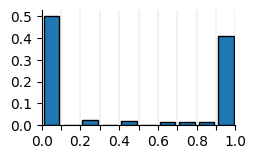

GRPO_no_std-offline


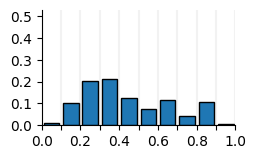

RLOO-offline


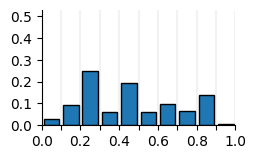

PPO-offline


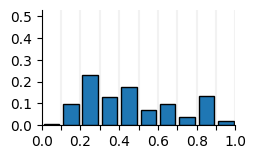

zero-shot


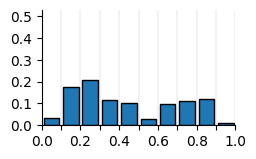

In [12]:
for k, df in dfs.items():
    print(k)
    plt.figure(figsize=(2.5, 1.5))
    x = np.arange(10)
    counts= df['answer_bin'].value_counts(normalize=True).to_dict()
    y = [counts.get(x[i], 0) for i in range(len(x))]
    plt.bar(x + 0.5, y, edgecolor="k")
    # _ = plt.xticks(ticks=x, labels=[f"{i*10}-{(i+1)*10}%" for i in range(10)], rotation=45, ha="right")
    # _ = plt.yticks(ticks=np.linspace(0, 0.5, 6), labels=[f"{i*10}%" for i in range(6)])
    xticks = np.arange(11)
    xlabels= ["{:.1f}".format(i/10) if i % 2 == 0 else "" for i in range(11)]
    plt.xticks(ticks=xticks, labels=xlabels)
    _ = plt.yticks(ticks=np.linspace(0, 0.5, 6))
    for i in range(11):
        plt.axvline(i, 0, 1, color="gray", alpha=0.1)
    plt.xlim(0, 10)
    plt.gca().spines[["right", "top"]].set_visible(False)
    # plt.gca().set_box_aspect(1)
    plt.ylim(0, 0.53)
    plt.savefig(outdir / f"pert_pred_dist_{k}.png", transparent=True, dpi=200, bbox_inches="tight")
    plt.show(plt.gcf())
    plt.close()

In [ ]:
plot_info = defaultdict(list)
for k, df in dfs.items():
    for i in range(10):
        curr = np.array(df[df["answer_bin"] == i]["hit"].astype(float))
        if len(curr) < 10:
            continue
        res = st.bootstrap((curr,), statistic=np.mean, confidence_level=0.95, n_resamples=10000, method="percentile", random_state=0)
        plot_info["model"].append(k)
        plot_info["bin"].append(i)
        plot_info["count"].append(len(curr))
        plot_info["freq"].append(len(curr) / len(df))
        plot_info["mean"].append(curr.mean())
        plot_info["ci_low"].append(res.confidence_interval.low)
        plot_info["ci_high"].append(res.confidence_interval.high)

plot_info = pd.DataFrame(plot_info)
plot_info["ci_low_diff"] = plot_info["mean"] - plot_info["ci_low"]
plot_info["ci_high_diff"] = plot_info["ci_high"] - plot_info["mean"]

['0.0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0']
GRPO-offline


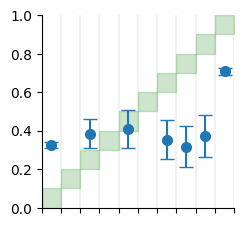

['0.0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0']
GRPO_no_std-offline


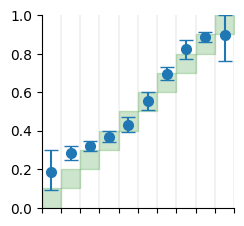

['0.0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0']
RLOO-offline


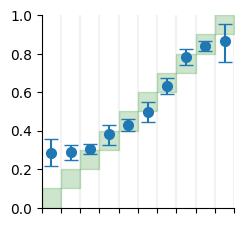

['0.0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0']
PPO-offline


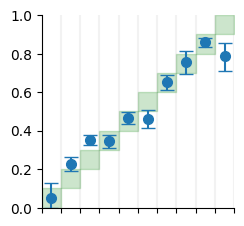

['0.0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0']
zero-shot


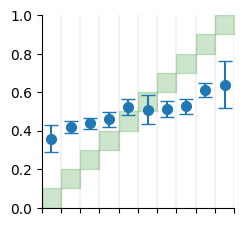

In [ ]:
for k in plot_info["model"].unique():
    plt.figure(figsize=(2.5, 2.5))
    curr = plot_info[plot_info["model"] == k]
    curr = curr[curr["count"] > 25]
    plt.errorbar(curr["bin"] + 0.5, curr["mean"], yerr=curr[["ci_low_diff", "ci_high_diff"]].to_numpy().T, capsize=5, fmt="o", markersize=7)

    for i in range(10):
        plt.fill_between([i, i+1], [i/10, i/10], [(i+1)/10, (i+1)/10], color="green", alpha=0.2, zorder=1)


    xticks = np.arange(11)
    xlabels= ["{:.1f}".format(i/10) if i % 2 == 0 else "" for i in xticks]
    print(xlabels)
    plt.xticks(ticks=xticks, labels=[])

    plt.xlim(0, 10)
    plt.ylim(0, 1)

    _ = plt.yticks(ticks=np.linspace(0, 1, 6))

    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.gca().set_box_aspect(1)
    for i in range(11):
        plt.axvline(i, 0, 1, color="gray", alpha=0.1)
    print(k)
    plt.savefig(outdir / f"pert_calibration_binned_{k}.png", transparent=True, dpi=200, bbox_inches="tight")

    plt.show(plt.gcf())
    plt.close()

In [ ]:
dfs["RLOO-offline"]

,pert,hit_prob,pheno,pheno_markers,hit,prompt,thinking_content,answer,answer_num,answer_bin,answer_bin_val
0,SBNO1,0.037642,1,"LRPPRC, HNRNPU, NCL, MT-ND4L, EIF4B, IPO5, EIF...",False,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",30,30.0,2,25.0
1,BRIP1,0.037643,1,"LRPPRC, HNRNPU, NCL, MT-ND4L, EIF4B, IPO5, EIF...",False,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",30,30.0,2,25.0
2,RCOR1,0.037694,1,"LRPPRC, HNRNPU, NCL, MT-ND4L, EIF4B, IPO5, EIF...",False,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",30,30.0,2,25.0
3,REXO2,0.037745,1,"LRPPRC, HNRNPU, NCL, MT-ND4L, EIF4B, IPO5, EIF...",False,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",45,45.0,4,45.0
4,NCAPD3,0.037827,1,"LRPPRC, HNRNPU, NCL, MT-ND4L, EIF4B, IPO5, EIF...",False,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",25,25.0,2,25.0
...,...,...,...,...,...,...,...,...,...,...,...
675,MAGOH,0.999806,50,"HSPA1A, HSPA1B, DNAJB1, HSP90AA1, HSPH1, UBC, ...",True,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",85,85.0,8,85.0
676,USP8,0.999920,50,"HSPA1A, HSPA1B, DNAJB1, HSP90AA1, HSPH1, UBC, ...",True,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",40,40.0,3,35.0
677,PSMD6,1.000000,50,"HSPA1A, HSPA1B, DNAJB1, HSP90AA1, HSPH1, UBC, ...",True,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",90,90.0,8,85.0
678,INTS8,1.000000,50,"HSPA1A, HSPA1B, DNAJB1, HSP90AA1, HSPH1, UBC, ...",True,<|im_start|>user\nI am planning a perturb-seq ...,"\nOkay, the user is planning a perturb-seq scr...",75,75.0,7,75.0
